# Assumptions

In [6]:
name_simulation = 'nuke_rupdown_0.01'

############################
# Imports...
############################

# Libraries
path_src = '../../src/'
%run -i {path_src}raw_import.py

current_path = os.getcwd()
os.makedirs(current_path + '/out/' + name_simulation + '/input', exist_ok=True)
os.makedirs(current_path + '/out/' + name_simulation + '/output', exist_ok=True)

############################
# To change
############################

number_of_mean_weeks = 4
profil_weeks = 'M4'

r = 0.04

cost_co2_2020 = 50 #€/t
cost_co2_2050 = 1000 #€/t

demand_growth = 0.01 # /year

# REN Load factors
loadfactor_won = 'medium' # choices : 'low' - 'medium' - 'high' - 'random'
loadfactor_wof = 'medium' # choices : 'low' - 'medium' - 'high' - 'random'
loadfactor_pv  = 'medium' # choices : 'low' - 'medium' - 'high' - 'random'

# REN costs
occ_won = 'low' # 'medium' or 'low'
occ_wof = 'low' # 'medium' or 'low'
occ_pv  = 'low' # 'medium' or 'low'

nuclear_hist_lifetime = 50 # either 40, 50 or 60

ramping = True

nuke_new_rup = 0.03 # %Pn/hour
nuke_new_rdo = nuke_new_rup


# Model

In [7]:
############################
# Time data
############################

# 52 weeks are concatened into small number of weeks in order to speed up the code execution
# Demand is rescale in order to get total annual demand similar
# 'average' groups weeks in a homogeneous way
# 'maxmin' use max demand week as week #1, min demand week as week #2 and random for others

number_of_mean_weeks = number_of_mean_weeks
profil_weeks = profil_weeks # choices : 'average' - 'maxmin' - 'M4'

# Time vectors
start_world = 1950
start_of_scenario = 2023
end_of_scenario = 2060

years = range(start_of_scenario, end_of_scenario +1)
weeks = range(1, number_of_mean_weeks +1)
hours = range(1, 24*7 +1)

years_world = range(start_world, end_of_scenario +1)

U = np.arange(0, 8760, 1)

############################
# Economic parameters
############################

# Discount rate 
r = r

# Carbone cost
cost_co2_2020 = cost_co2_2020 #€/t
cost_co2_2050 = cost_co2_2050 #€/t
#a = (cost_co2_2050 - cost_co2_2020)/(2050-2020)
#b = (2050*cost_co2_2020 - 2020*cost_co2_2050)/(2050-2020)
#cost_co2 = {y: a*y+b for y in years} # €/t

# Demand evolution
demand_growth = demand_growth # /year

# REN Load factors
loadfactor_won = loadfactor_won # choices : 'low' - 'medium' - 'high' - 'random'
loadfactor_wof = loadfactor_wof # choices : 'low' - 'medium' - 'high' - 'random'
loadfactor_pv  = loadfactor_pv  # choices : 'low' - 'medium' - 'high' - 'random'

# REN costs
occ_won = occ_won # 'medium' or 'low'
occ_wof = occ_wof # 'medium' or 'low'
occ_pv  = occ_pv  # 'medium' or 'low'

############################
# Scenario data and parameters
############################

nuclear_hist_lifetime = nuclear_hist_lifetime # either 40, 50 or 60
ramping = ramping

############################
# choix d'affichage des courbes
############################

Display_input={}

Display_input['demand']      = True # Demand evolution

Display_input['fix_costs']   = True # Cout fix des technos dans le temps -> all years
Display_input['tot_costs']   = True # Cout total des technos dans le temps -> in years

Display_input['hist_data']   = True # Historical data

Display_input['carbon_cost'] = True # CO2 Cost - Here taken from CCGT

Display_input['week_demand'] = True # Week representative demand
Display_input['week_pv']     = True # PV Load Factor representative week 
Display_input['week_won']    = True # WON Load Factor representative week 
Display_input['week_wof']    = True # WOF Load Factor representative week

Display_input['load_factor_total'] = False # Wind Load Factor analysis 
Display_input['load_factor_data']  = False # data Load Factor analysis

Display_input['nuclear_hist']      = False # data Load Factor analysis

############################
# Imports...
############################

# Functions
%run -i {path_src}func/distance_cluster.py
%run -i {path_src}func/R_M4_Demand.py
%run -i {path_src}func/aff_analyse_fc.py
%run -i {path_src}func/dictionary.py

# Parameters generic
%run -i {path_src}classes/parameters/generic/class_prm_eco.py
%run -i {path_src}classes/parameters/generic/class_prm_tech.py

# Parameters specific
%run -i {path_src}classes/parameters/specific/class_prm_dispatchable.py
%run -i {path_src}classes/parameters/specific/class_prm_fatal.py
%run -i {path_src}classes/parameters/specific/class_prm_storage.py

# Technologies
%run -i {path_src}/classes/class_technos.py

# Progress bar
%run -i {path_src}func/progress_bar.py

opt_model = cpx.Model(name="cineaste model")

print(50*'-','\n','Importing classes ... OK')
print(50*'-')

############################
# Misc...
############################

############################
# demand
############################

# Get exactly 52 weeks... Remove last elements.
demand = np.loadtxt('../../../data/formatted/demand/2019.inc')[:int(7*24*52)]
# Build dataframe with matrix form
demand_reshape = pd.DataFrame(np.array(demand).reshape(-1, 7 * 24))
# compute the total demand in the year
demand_total = demand_reshape.values.sum()

if profil_weeks == 'average':
    group = np.arange(len(demand_reshape)) // (52 / number_of_mean_weeks) # group est une matrice
    # Average by grouping according to number_of_mean_weeks
    demand_average = demand_reshape.groupby(group).mean()

elif profil_weeks == 'maxmin':
    # Find the row with maximum demand
    max_row_index = demand_reshape.idxmax().iloc[0]
    max_row = demand_reshape.loc[[max_row_index]]
    # Find the row with minimum demand
    min_row_index = demand_reshape.idxmin().iloc[0]
    min_row = demand_reshape.loc[[min_row_index]]    
    # Select random rows
    random_rows_indices = np.random.choice(demand_reshape.index, size=number_of_mean_weeks-2, replace=False)
    random_rows = demand0._reshape.loc[random_rows_indices]
    # Concatenate all selected rows into a new DataFrame
    demand_average = pd.concat([max_row, min_row, random_rows])
    demand_average.reset_index(drop=True, inplace=True)
    # Calculate total of demand average
    demand_average_total = demand_average.values.sum()
    # Rescale demand_average in order to have the same energy production
    demand_average = demand_average * demand_total / (demand_average_total * 52/number_of_mean_weeks)

elif profil_weeks == 'M4' :
    group=R_M4_Demand(number_of_mean_weeks, demand_reshape, print_info=False) # 'aff_analyse'= True pour l'aff des courbes d'analyse
    demand_average = demand_reshape.groupby(group).mean()

else:
    print('ERROR : Possible choices for profil_weeks... ')
    print('- average')
    print('- maxmin')
    print('Current choice is : ',profil_weeks)

# Iterate over the DataFrame and populate the dictionary demand
demand_dict = {(y,w,h): demand_average.iloc[w-1, h-1]*(1+demand_growth)**(y-years[0]) for y in years for w in weeks for h in hours}

# Dict that contains index of week : number of weeks in group
weight_week_dict=dict(Counter(group))
weight_week_dict = {key + 1: value for key, value in weight_week_dict.items()} # w : weight with w in weeks

print(50*'-','\n','Importing demand ... OK')
print(50*'-')

############################
# production
############################

techno = {} # dict of output for each year : techno_d[index] => techno dispatchable

#---------------------------
# Dispatchable
#---------------------------

index = 1
%run -i nuclear/historic.py

%run -i nuclear/new.py

%run -i gas/ccgt.py

#---------------------------
# REN
#---------------------------

%run -i ren/won.py '../../../data/formatted/ren/wind/onshore/2019.inc'
%run -i ren/wof.py '../../../data/formatted/ren/wind/offshore/2019.inc'
%run -i ren/pv.py '../../../data/formatted/ren/solar/pv/2019.inc'

#print(pt_ren_won.get_LF())

#---------------------------
# Hydro lake and ROR
#---------------------------

%run -i hydro/ror.py '../../../data/formatted/hydro/ror/2019.inc'
%run -i hydro/lake.py '../../../data/formatted/hydro/lake/2019.inc'

#---------------------------
# Other Fatal
#---------------------------

%run -i gas/cogen.py '../../../data/formatted/gas/cogen/2019.inc'

#---------------------------
# Storage
#---------------------------

%run -i hydro/step.py

#---------------------------
# Interconnexions
#---------------------------


print(50*'-','\n','Importing technos ... OK')
print(50*'-')

#---------------------------
# Plots
#---------------------------

year = 2023
%run -i {path_src}func/plot_input.py

############################################################################
# MODEL
############################################################################

opt_model.clear()

max_P = max(demand_dict.values())

############################################################################
# Variables
############################################################################

# Installed capacity
var_P = {(i, y): opt_model.continuous_var(name=f'var_P_{i}_{y}', lb=0, ub=max_P)
        for i in techno.keys() for y in years}

# Investment in capacities
var_Inv = {(i, y): opt_model.continuous_var(name=f'var_Inv_{i}_{y}', lb=0, ub=max_P)
        for i in techno.keys() for y in range(years.start-1, years.stop-1)}

# Decommissioning in capacities
var_Dec = {(i, y): opt_model.continuous_var(name=f'var_Dec_{i}_{y}', lb=0, ub=max_P)
        for i in techno.keys() for y in range(years.start-1, years.stop-1)}

# Energy produced by all
var_E = {(i,y,w,h): opt_model.continuous_var(name=f'var_E_{i}_{y}_{w}_{h}', lb=-max_P, ub=max_P)
        for i in techno.keys() for y in years for w in weeks for h in hours}

# Storage Energy Level
var_SE={(i,y,w,h) : opt_model.continuous_var(name=f'var_SE_{i}_{y}_{w}_{h}', lb=0, ub=max_P*8760)
        for i in techno.keys() for y in years for w in weeks for h in hours}

print(50*'-','\n','Variable declaration ... OK')
print(50*'-')

############################################################################
# Intermediate Parameters 
############################################################################

annuities = {}
annual_fix_cost_tot = {}

############################################################################
# Constraints
############################################################################

# ----------------------------------------------
# Sum_{tec} (supply (tec,y,h)) >= Demand (y,t)
# >= or == according to curtailment
# ----------------------------------------------

# Precompute sum values for each (y,w,h) combination
sum_var_E  = {(y,w,h): opt_model.sum(var_E[i,y,w,h] for i in techno.keys()) for y in years for w in weeks for h in hours}

for y in years:
    # ----------------------------------------------
    # sum(P) >= max demand
    # ----------------------------------------------
#    max_P_y = max(demand_dict[y,w,h] for w in weeks for h in hours)
    for w in weeks:
#        opt_model.add_constraint(ct = opt_model.sum( var_P[i,y] for i in techno.keys() ) >= max_P_y )
        for h in hours:
            # ----------------------------------------------
            # sum_t[var_E(t,y,h)] = Demand(y,h)]
            # ----------------------------------------------
            opt_model.add_constraint(ct = sum_var_E[y,w,h] == demand_dict[y,w,h])
                
# ----------------------------------------------
# All
# i => index
# t => Techno[i]
# tec  => Techno[i].get_tech()
# eco  => Techno[i].get_eco()
# spec => Techno[i].get_spec()
# ----------------------------------------------


for i, t in tqdm(techno.items(), desc="Processing", unit="Techno"):
    is_fatal   = (t.get_type() == 'fatal')
    tec  = t.get_tech()
    eco  = t.get_eco()
    spec = t.get_spec()
    is_storage = (t.get_type() == 'storage')
    is_P_var = tec.get_isPvar()
    is_E_var = tec.get_isEvar()
    P = tec.get_P()
    E = tec.get_E()
    titre = t.get_title()
    name = t.get_name()
 
    ### Energie et Puissance positive
    if not is_storage : 
        for y in years : 
            for w in weeks : 
                for h in hours : 
                    #### E positive ####### 
                    opt_model.add_constraint(ct = var_E[i,y,w,h] >= 0 ) 
                    opt_model.add_constraint(ct = var_SE[i,y,w,h] == 0 ) 
 
    # ----------------------------------------------
    # INVESTMENT/DECOMISSIONING CONSTRAINT
    # ----------------------------------------------
    for y in years:
        if is_P_var[y]:

            # Investment maximum per year
            opt_model.add_constraint(ct = var_Inv[i,y-1] <= tec.get_InvMax()[y-1])
            # Decommisionnning @y
            if ( y - eco.get_lt()) <= years.start-1:
                opt_model.add_constraint(ct = var_Dec[i,y-1] == tec.get_historic_data('INV')[y-1 - eco.get_lt()])
            else: 
                opt_model.add_constraint(ct = var_Dec[i,y-1] == var_Inv[i,y-1 - eco.get_lt()])

        # Linking
            if y == years.start:
                # Linking
                opt_model.add_constraint(ct = var_P[i,y] == tec.get_historic_data('CAPA')[y-1] + var_Inv[i,y-1] - var_Dec[i,y-1])
                    
            else:
                # Power
                opt_model.add_constraint(ct = var_P[i,y] == var_P[i,y-1] + var_Inv[i,y-1] - var_Dec[i,y-1])
                
        else:
            opt_model.add_constraint(ct = var_Inv[i,y-1] == 0)
            opt_model.add_constraint(ct = var_Dec[i,y-1] == 0)
            opt_model.add_constraint(ct = var_P[i,y] == P[y])

    # ----------------------------------------------
    # END OF INVESTMENT PART
    # ----------------------------------------------

    for y in years:
        for w in weeks:
            for h in hours:
                # ----------------------------------------------
                # E(i,y,w,h) <= P(i,y) * 1h * availability(i,y,w) for each machines
                # ----------------------------------------------
                if t.get_tech().get_A() is not None:
                    avail = t.get_tech().get_A()[y,w]
                else:
                    avail = 1
                opt_model.add_constraint(ct = var_E[i,y,w,h] <= var_P[i,y] * 1 * avail)
    
            for h in hours:
                if not is_E_var[y,w,h]:
                    # ----------------------------------------------
                    # E Exogeneous variable => Fixed
                    # ----------------------------------------------
                    opt_model.add_constraint(ct = var_E[i,y,w,h] == E[y,w,h])
    if is_fatal:
        for y in years:
            for w in weeks:
                for h in hours:
                    # ----------------------------------------------
                    # Fatal energy : E(i,y,h) = LF(i,y,h) * P(i,y)
                    # ----------------------------------------------
                    opt_model.add_constraint(ct = var_E[i,y,w,h] == tec.get_LF()[y,w,h] * var_P[i,y])

    # ----------------------------------------------
    # Ramping : Energy
    # ----------------------------------------------
    if ramping: 
        if not is_fatal:
            rup = spec.get_rup()
            rdo = spec.get_rdo()
            for y in years:
                for w in weeks:
                    for h in hours:
                        if is_E_var[y,w,h]:
                            if (h == hours.stop-1):
                                if (w == weeks.stop-1):
                                    if (y == years.stop-1):
                                        pass
                                    else:
                                        opt_model.add_constraint(ct = var_E[i,y+1,1,1] <= var_E[i,y,w,h] + var_P[i,y+1]*rup)
                                        opt_model.add_constraint(ct = var_E[i,y+1,1,1] >= var_E[i,y,w,h] - var_P[i,y+1]*rdo)
                                else:
                                    opt_model.add_constraint(ct = var_E[i,y,w+1,1] <= var_E[i,y,w,h] + var_P[i,y]*rup)
                                    opt_model.add_constraint(ct = var_E[i,y,w+1,1] >= var_E[i,y,w,h] - var_P[i,y]*rdo)
                            else: 
                                opt_model.add_constraint(ct = var_E[i,y,w,h+1] <= var_E[i,y,w,h] + var_P[i,y]*rup)
                                opt_model.add_constraint(ct = var_E[i,y,w,h+1] >= var_E[i,y,w,h] - var_P[i,y]*rdo)
         
    # ----------------------------------------------
    # Reserve Capacity (Cf Perrier)
    # ----------------------------------------------
 
    # ----------------------------------------------
    # Storage : STEP
    # ----------------------------------------------
    if is_storage and titre=='charge' :
        
        i_charge = i
        i_discharge = i+1

        level_max   = spec.get_level_max()
        level_min   = spec.get_level_min()
        level_start = spec.get_level_start()

        tec_charge    = tec
        tec_discharge = techno[i_discharge].get_tech()
        
        eff_charge    = spec.get_efficiency_charge()
        eff_discharge = spec.get_efficiency_discharge() 
        
        for y in years:
            for w in weeks:
                for h in hours:
                    # ----------------------------------------------
                    # E(i,y,h) <= P(i,y) * 1h for each machines
                    # ----------------------------------------------
                    opt_model.add_constraint(ct = var_E[i_discharge,y,w,h] <= var_P[i_discharge,y] * 1 )
                    opt_model.add_constraint(ct = var_E[i_discharge,y,w,h] >= 0 )
                    opt_model.add_constraint(ct = var_E[i_charge,y,w,h] <= 0 )
                    opt_model.add_constraint(ct = 0 - var_E[i_charge,y,w,h] <= var_P[i_charge,y] * 1 )
 
        for y in years:
            for w in weeks : 
                for h in hours:
                    # E > 0 => EC = 0 and E = 0 => EC >= 0
                    # opt_model.add_constraint(var_E[i_charge,y,h]*var_EC[i_charge,y,h] == 0) => Not linear !!
 
                    # Stocke i et i_discharge les même 
                    opt_model.add_constraint(ct = var_SE[i_charge,y,w,h] == var_SE[i_discharge,y,w,h])
 
                    # We start from the level start
                    if y==years[0] and w==weeks[0] and h==hours[0] :  
                        opt_model.add_constraint(ct = var_SE[i,y,w,h] == level_start)

                    # First week and first hour of a year which is not the first year
                    elif w==weeks[0] and h==hours[0] and y!=years[0]:
                        opt_model.add_constraint(ct = var_SE[i,y,w,hours[0]] == -1*eff_charge*var_E[i_charge,y,w,h] 
                                                                                -1/eff_discharge*var_E[i_discharge,y,w,h]
                                                                                + (var_SE[i,y-1,weeks[-1],hours[-1]] - var_SE[i,y-1,weeks[-1],hours[0]])*weight_week_dict[weeks[-1]]
                                                                                + var_SE[i,y-1,weeks[-1],hours[0]])
                    # First hour of a year/week which is not the first year/week
                    elif h==hours[0] and w!=weeks[0]:
                        opt_model.add_constraint(ct = var_SE[i,y,w,h] == -1*eff_charge*var_E[i_charge,y,w,h] 
                                                                         -1/eff_discharge*var_E[i_discharge,y,w,h]
                                                                         + (var_SE[i,y,w-1,hours[-1]] - var_SE[i,y,w-1,hours[0]])*weight_week_dict[w-1]
                                                                         + var_SE[i,y,w-1,hours[0]])

                    # Usual case
                    else : 
                        opt_model.add_constraint(ct = var_SE[i,y,w,h] == -1*eff_charge*var_E[i_charge,y,w,h] 
                                                                         -1/eff_discharge*var_E[i_discharge,y,w,h]
                                                                         + var_SE[i,y,w,h-1])

                                                  
                    opt_model.add_constraint(ct = var_SE[i,y,w,h]  <= level_max)
                    opt_model.add_constraint(ct = var_SE[i,y,w,h]  >= level_min)

    # ----------------------------------------------
    # Variable for Cost function
    # ----------------------------------------------
    for y in years:

        if eco.is_cap():
            annuities[i,y] = opt_model.sum( (tec.get_historic_data('INV')[yp-1] * eco.get_fix_cap()[yp-1] if yp < start_of_scenario else var_Inv[i, yp-1] * eco.get_fix_cap()[yp-1])
                                              for yp in range(y - eco.get_lt(), y + 1) )
        else:
            annuities[i,y] = eco.get_fix_dep()[y] * var_P[i,y]

        annual_fix_cost_tot[i,y] = annuities[i,y] + (eco.get_fix_om()[y] + eco.get_fix_mi()[y])*var_P[i,y] 
        
######################################
# Obj function + Solve
######################################

# Levelization
lev = {}
for y in years:
    lev[y] = 1/(1+r)**(y-start_of_scenario)

# Residual values of installations
res = {}
for i, t in techno.items():
    res[i] = 0
    for y in years[:-1]:
        if is_P_var[y]:
            age = years.stop-1 - y
            res[i] += var_Inv[i,y] * (t.get_eco().get_lt() - age)/t.get_eco().get_lt()

    
sum_fixed_cost    = {(y): opt_model.sum(annual_fix_cost_tot[i,y] for i in techno.keys()) for y in years}
sum_variable_cost = {(y,w,h): opt_model.sum(var_E[i,y,w,h] * techno[i].get_eco().get_var_tot()[y]*weight_week_dict[w] for i in techno.keys()) for y in years for w in weeks for h in hours}

# Total cost 
objective = opt_model.sum(sum_fixed_cost[y]*lev[y] for y in years) + \
            opt_model.sum(sum_variable_cost[y,w,h]*lev[y] for y in years for w in weeks for h in hours) - \
            opt_model.sum(res[i] * lev[years.stop-1] for i in techno.keys())

# Solve
opt_model.minimize(objective)
progress_listener = MyProgressListener(interval=1)
opt_model.add_progress_listener(progress_listener)
solution = opt_model.solve(log_output=True)

print('---------------------------------------------------')
print('--- Solution status')
print('---------------------------------------------------')
print("Solution status:", opt_model.solve_details.status)
print("Objective value:", format(opt_model.objective_value, ".2e"),'€')
print("Time spent in solving:", format(opt_model.solve_details.time, ".3g"),'s')

######################################
# Store data
######################################

for i, t in tqdm(techno.items(), desc="Processing", unit="Techno"):
    is_storage = (t.get_type() == 'storage')
    P1,P2,Dec1,Dec2,Inv1,Inv2,E = {},{},{},{},{},{},{}
    for y in years_world[+1:]:
        if y < start_of_scenario:
            if t.get_eco().is_cap():
                if y in t.get_tech().get_historic_data('CAPA'):
                    P1[y]     = t.get_tech().get_historic_data('CAPA')[y]
                if (y-1) in t.get_tech().get_historic_data('DEC'):
                    Dec1[y-1] = t.get_tech().get_historic_data('DEC')[y-1]
                if (y-1) in t.get_tech().get_historic_data('INV'):
                    Inv1[y-1] = t.get_tech().get_historic_data('INV')[y-1]
        else:
            P2[y] = var_P[i,y].solution_value
            Dec2[y-1] = var_Dec[i,y-1].solution_value
            Inv2[y-1] = var_Inv[i,y-1].solution_value
            for w in weeks:
                for h in hours:   
                    E[y,w,h] = var_E[i,y,w,h].solution_value
    if is_storage :
        SE = {(y,w,h): var_SE[i,y,w,h].solution_value for y in years for w in weeks for h in hours}
        t.get_spec().set_level(copy.deepcopy(SE))
    
    t.get_tech().set_P(copy.deepcopy({**P1, **P2}))
    t.get_tech().set_Dec(copy.deepcopy({**Dec1, **Dec2}))
    t.get_tech().set_Inv(copy.deepcopy({**Inv1, **Inv2}))    
    t.get_tech().set_E(copy.deepcopy(E))


-------------------------------------------------- 
 Importing classes ... OK
--------------------------------------------------
-------------------------------------------------- 
 Importing demand ... OK
--------------------------------------------------
-------------------------------------------------- 
 Importing technos ... OK
--------------------------------------------------
-------------------------------------------------- 
 Variable declaration ... OK
--------------------------------------------------


Processing: 100%|██████████████████████| 11/11 [01:00<00:00,  5.48s/Techno]


Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 16 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 14 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 1022838 rows and 327127 columns.
Aggregator did 88451 substitutions.
Reduced LP has 345507 rows, 147468 columns, and 977955 nonzeros.
Presolve time = 2.02 sec. (931.89 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =  265800161624.164886
Iteration:  2246   Dual objective     =  301055899581.292114
Iteration:  3648   Dual objective     =  317392255656.566956
Iteration:  4432   Dual objective     =  325045924404.104126
Iteration:  4919   Dual objective     =  332094032899.529297
Iteration:  5258   Dual objective     =  336454585748.360596
Iteration:  5536   Dual objective     =  341159506163.464478
Iteration:  5690   Dual

Processing: 100%|██████████████████████| 11/11 [00:02<00:00,  4.97Techno/s]


# Plot outputs

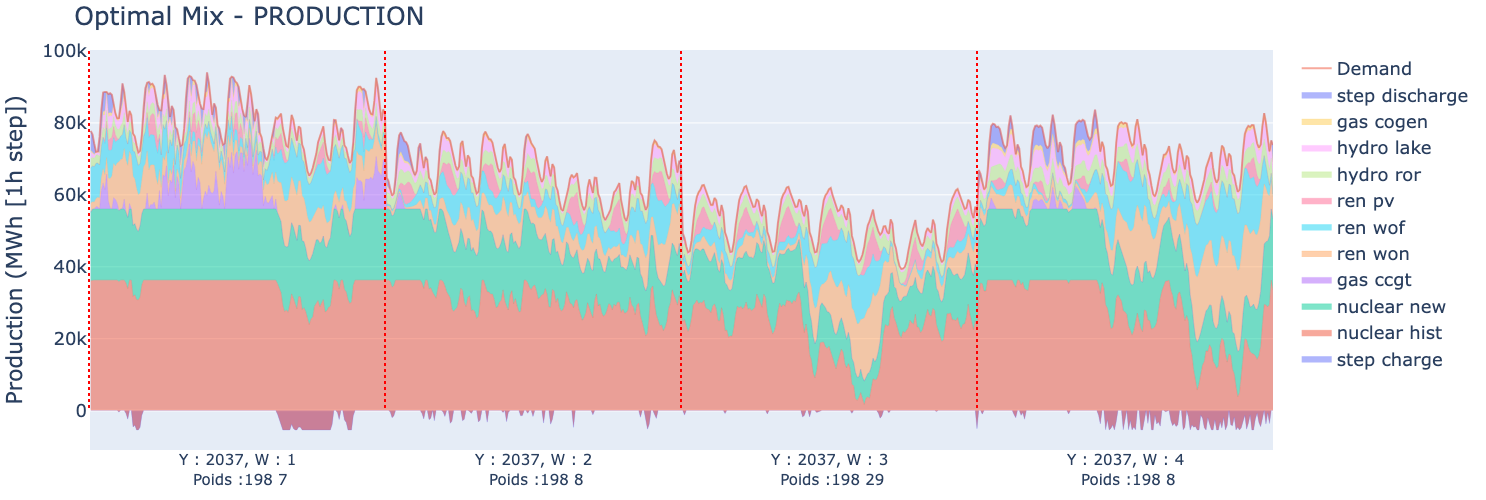

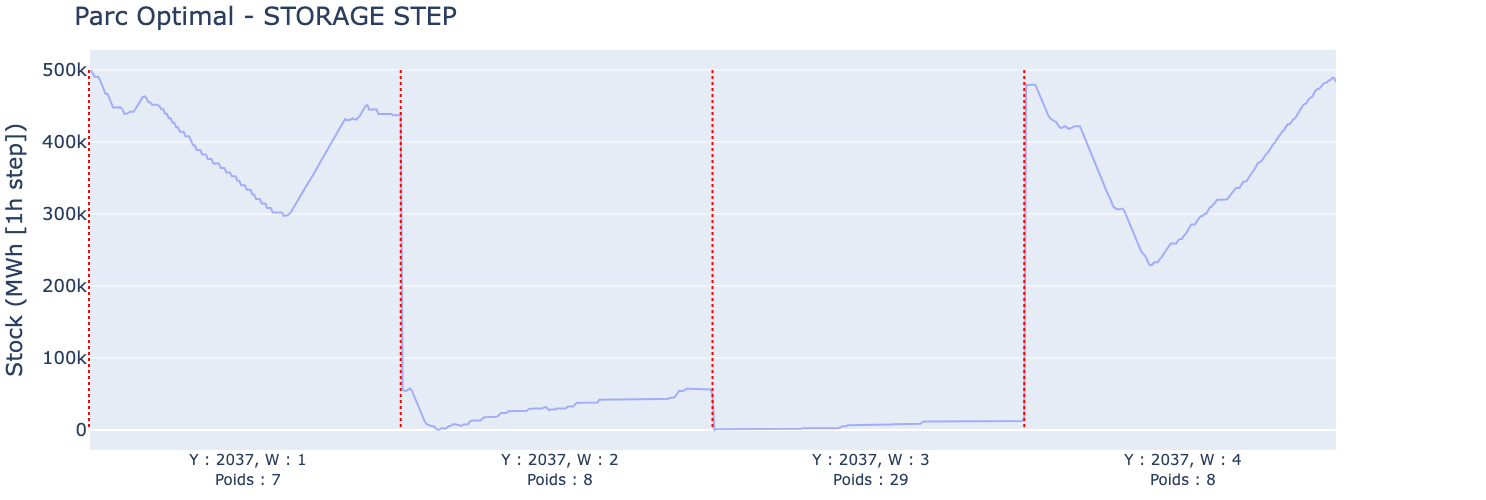

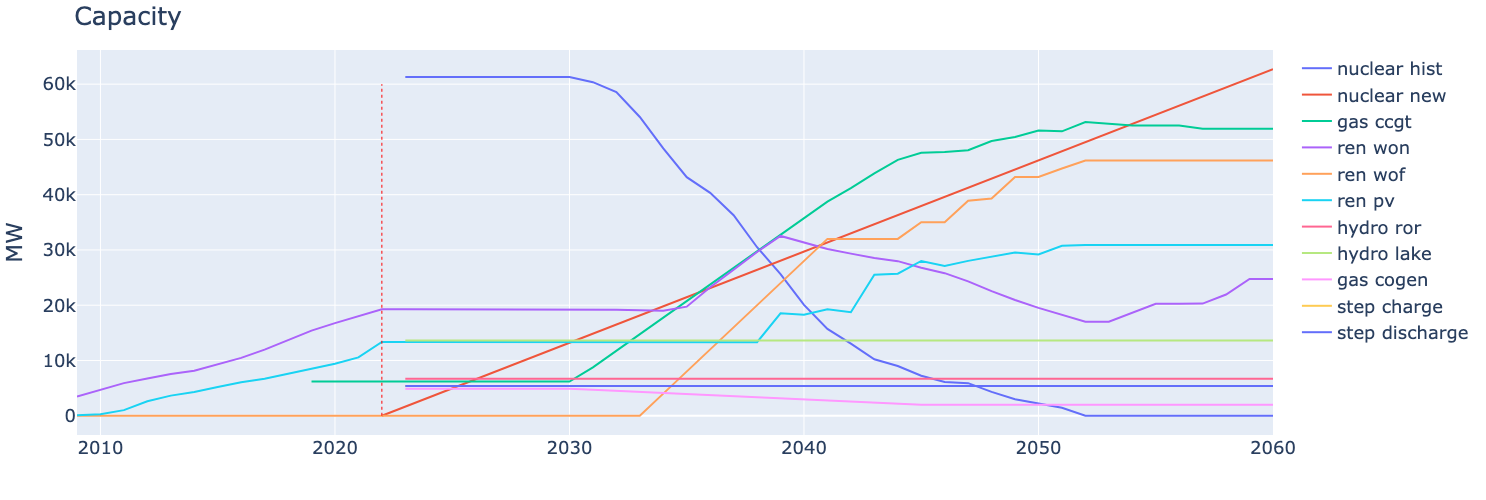

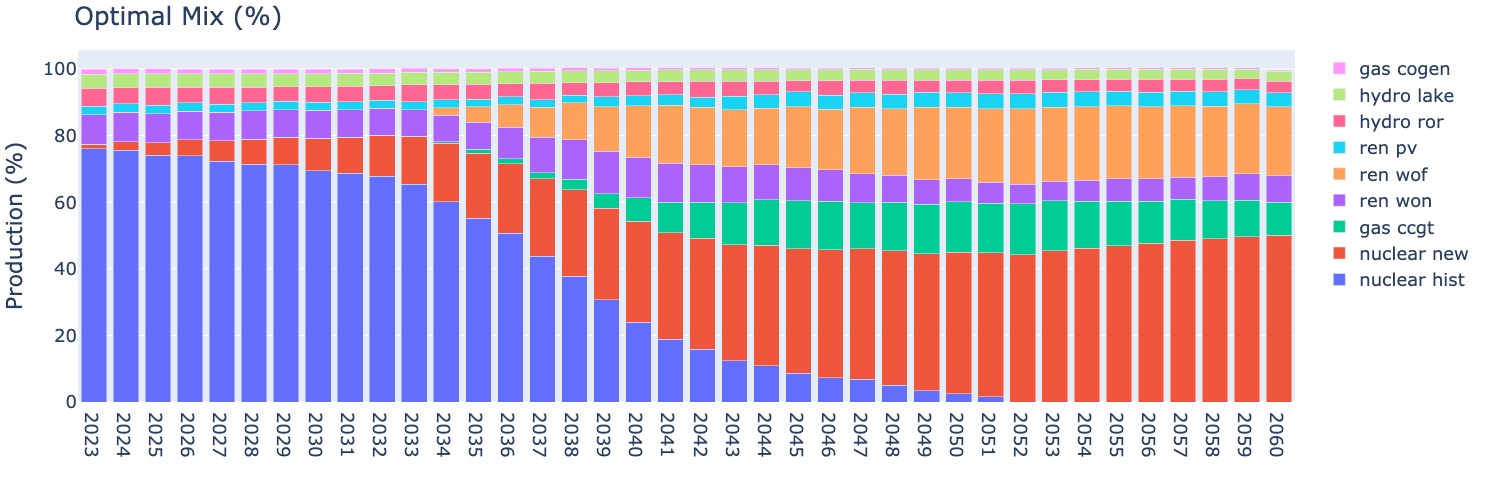

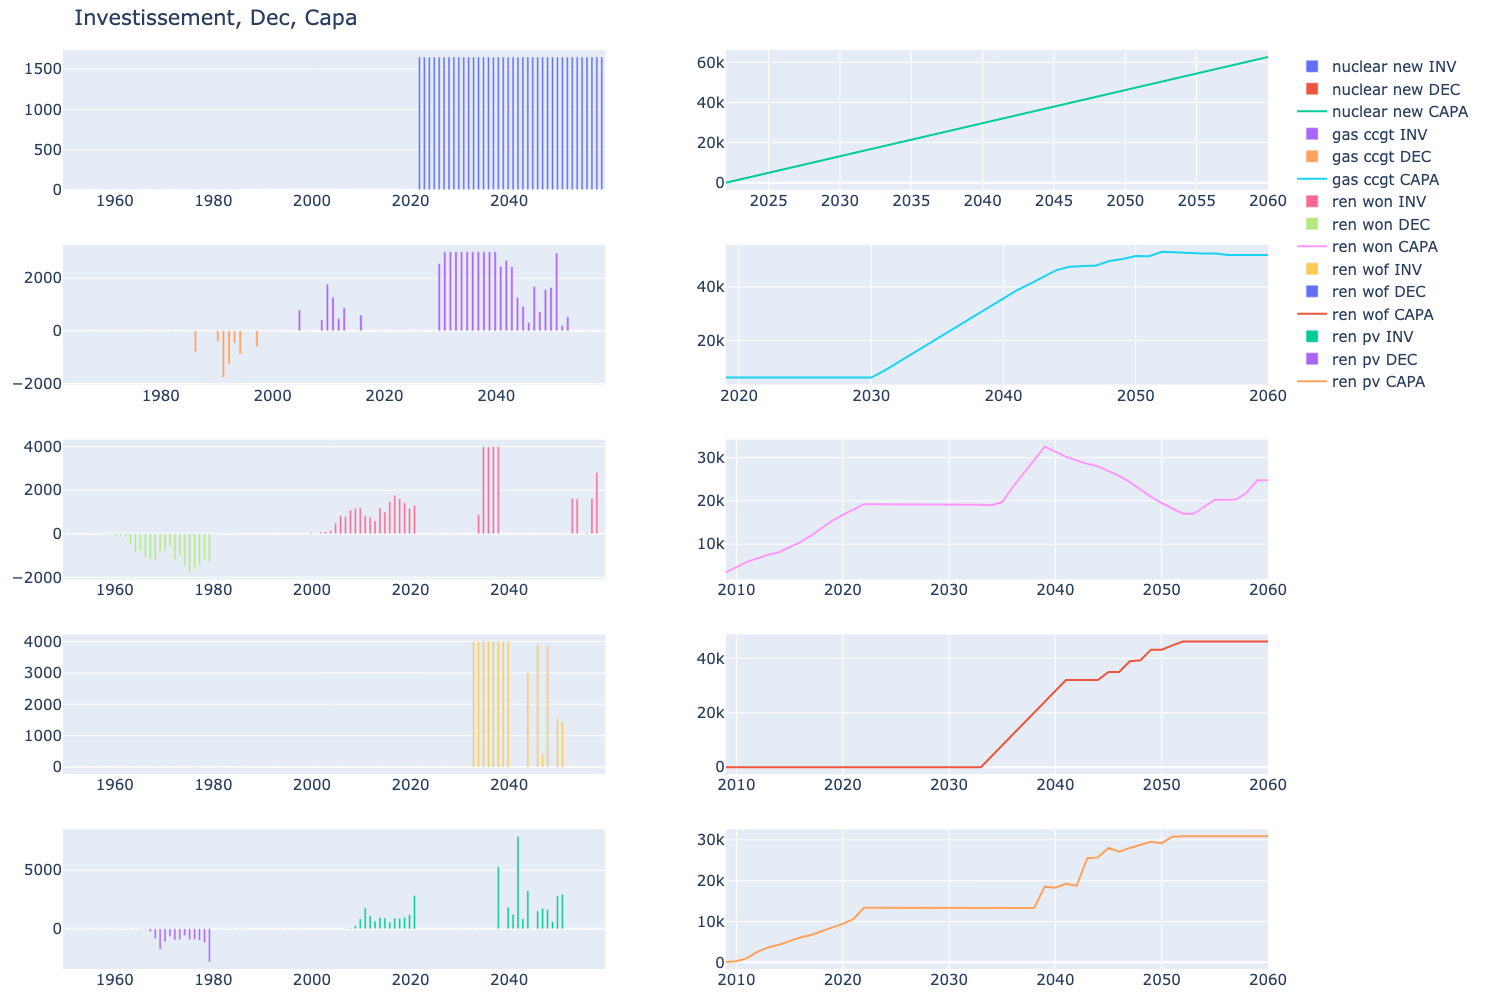

In [8]:
year_start = 2037
week_start = 1
nombre_week_affichage = 4

Display_output = {}
Display_output['production']   = True
Display_output['stock']        = True
Display_output['capacity']     = True
Display_output['mix']          = True
Display_output['inv_dec_capa'] = True

%run -i {path_src}func/plot_output.py
